In [25]:
import gridemissions as ge
import pandas as pd
from pathlib import Path
from typing import Union, List

In [60]:
def load_bulk(path: Union[str, Path], which: str = "elec") -> ge.GraphData:
    if isinstance(path, str):
        path = Path(path)
    if which not in ["elec", "co2", "co2i", "raw", "basic", "rolling", "opt"]:
        raise ValueError(f"Unexpected value for which: {which}")
    files = [f for f in path.iterdir() if f.name.endswith(f"{which}.csv")]
    gd = ge.GraphData(
        pd.concat(
            [pd.read_csv(path, index_col=0, parse_dates=True) for path in files],
            axis=0,
        )
    )
    gd.df.sort_index(inplace=True)
    gd.df = gd.df[~gd.df.index.duplicated(keep="last")]

    return gd


In [61]:
elec = load_bulk("../data/interim/gridemissions", "elec")

In [62]:
co2i = load_bulk("../data/interim/gridemissions", "co2i")

In [67]:
co2 = load_bulk("../data/interim/gridemissions", "co2")

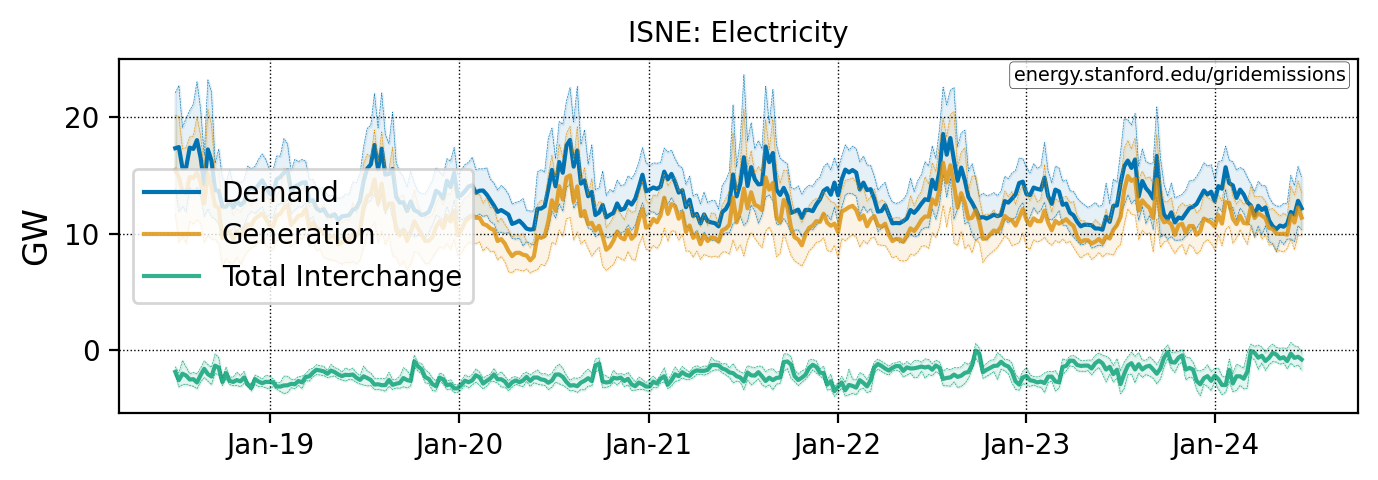

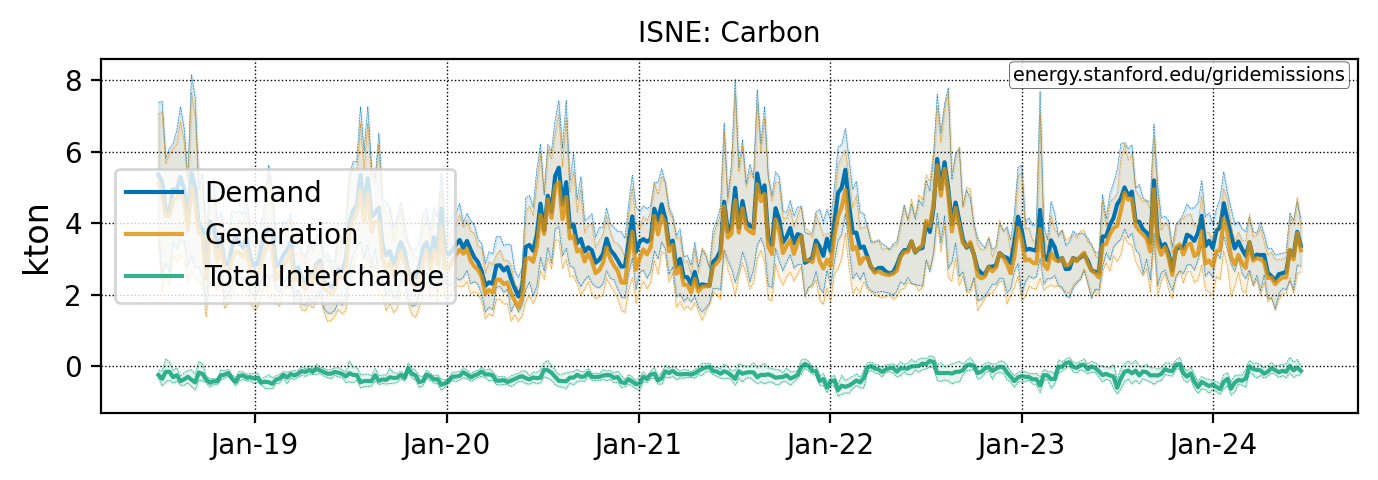

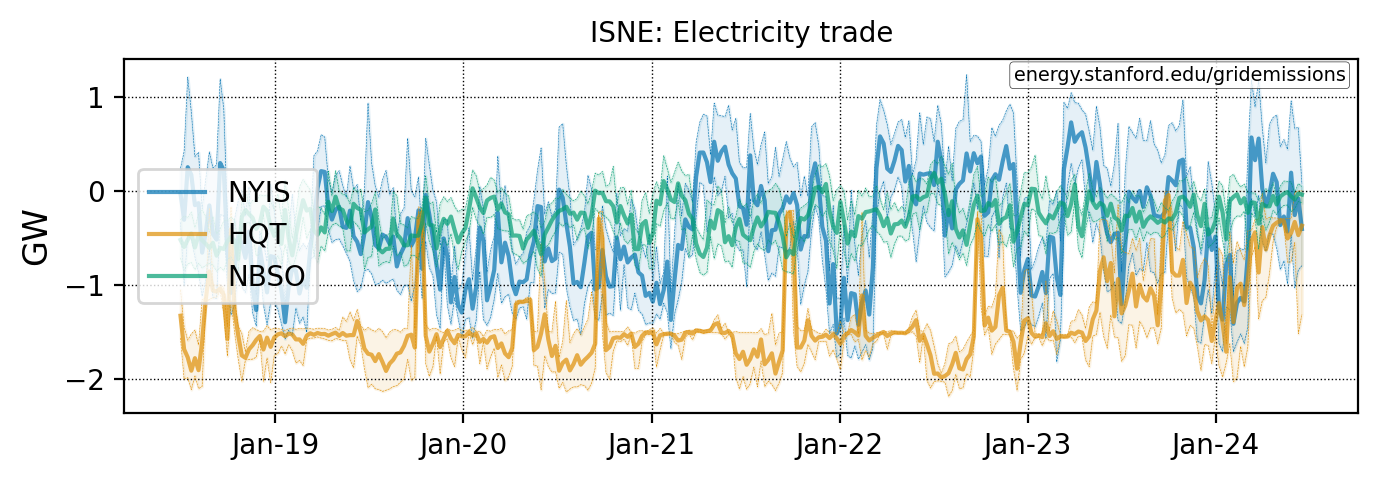

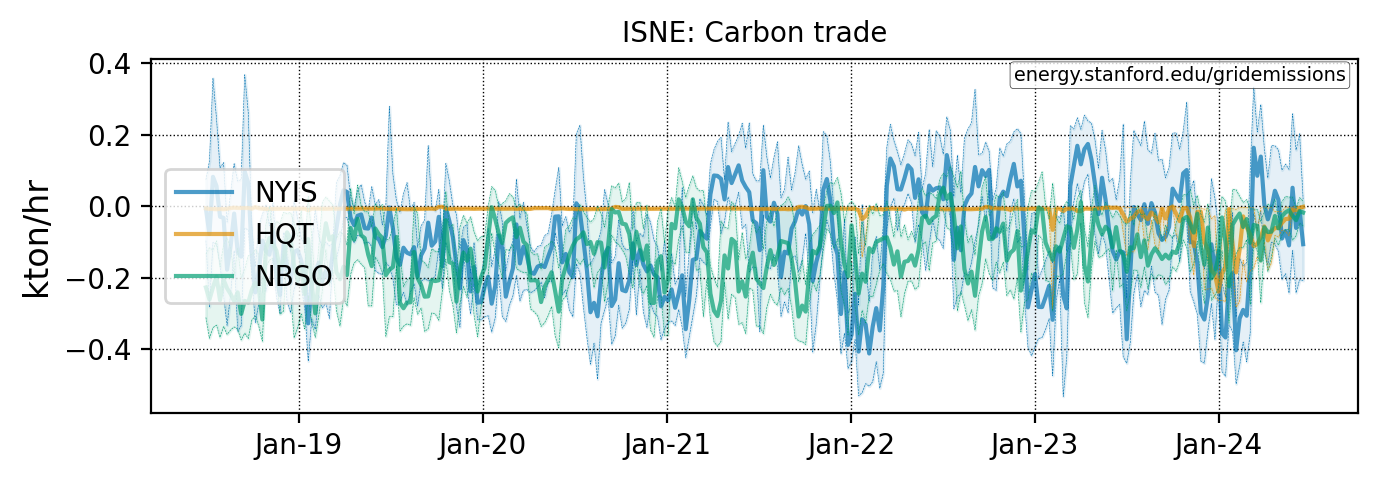

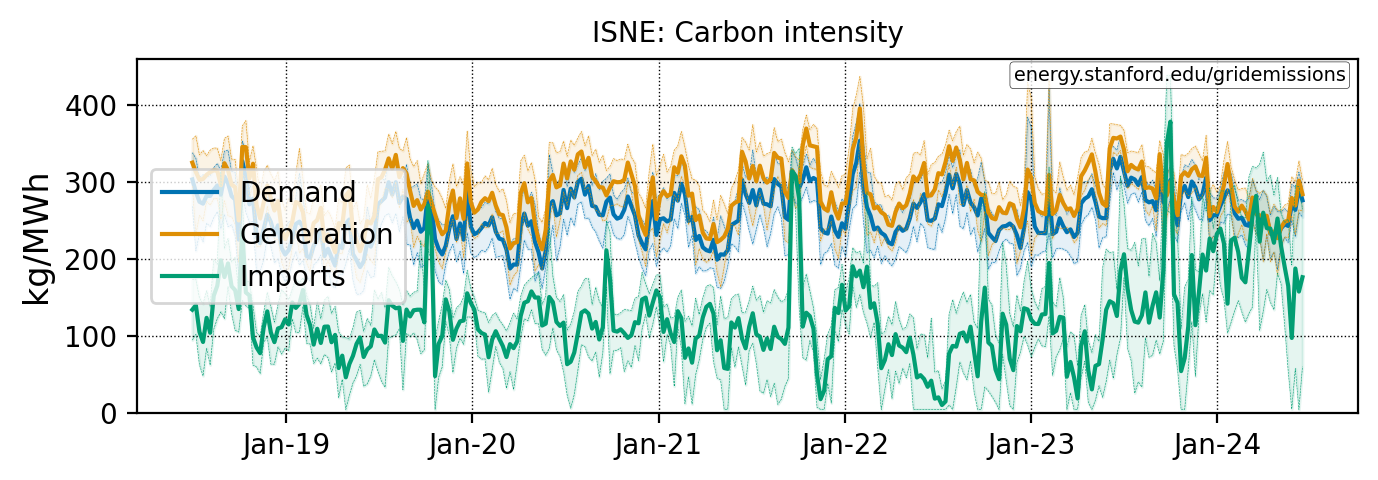

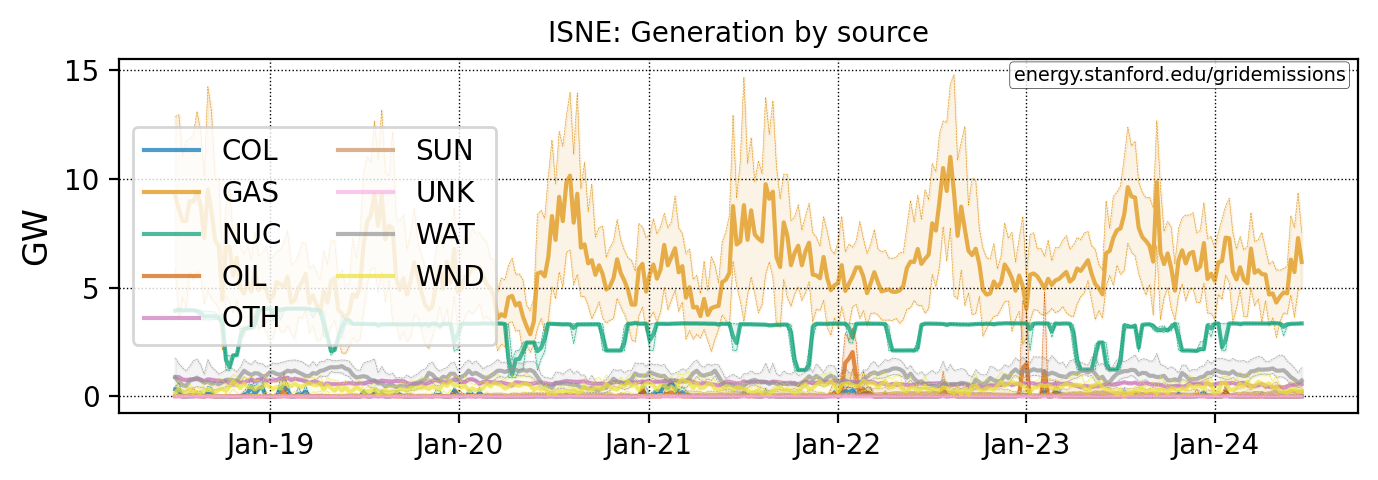

In [69]:
from gridemissions.viz import set_plots
from gridemissions.viz.reports import timeseries_report

COLORS, PAGE_WIDTH, ROW_HEIGHT = set_plots()
timeseries_report(co2, elec, regions=["ISNE"])

In [74]:
ba = "ISNE"
co2iD = (
        co2.get_data(region=ba, field="D")
        / elec.get_data(region=ba, field="D")
    )
co2iD

period
2018-07-01 05:00:00    282.989417
2018-07-01 06:00:00    273.393594
2018-07-01 07:00:00    274.670704
2018-07-01 08:00:00    273.813093
2018-07-01 09:00:00    269.970188
                          ...    
2024-06-15 03:00:00    290.016321
2024-06-15 04:00:00    283.324206
2024-06-15 05:00:00    291.796152
2024-06-15 06:00:00    285.924739
2024-06-15 07:00:00    277.681349
Length: 52227, dtype: float64

In [78]:
co2iD2 = co2i.get_data(region=ba, field="D")

In [82]:
import numpy as np
np.allclose(co2iD, co2iD2, equal_nan=True)

False

In [84]:
co2iD.values.flatten()[np.argmax(np.abs(co2iD - co2iD2))]

348.01847818886034

<Axes: xlabel='period'>

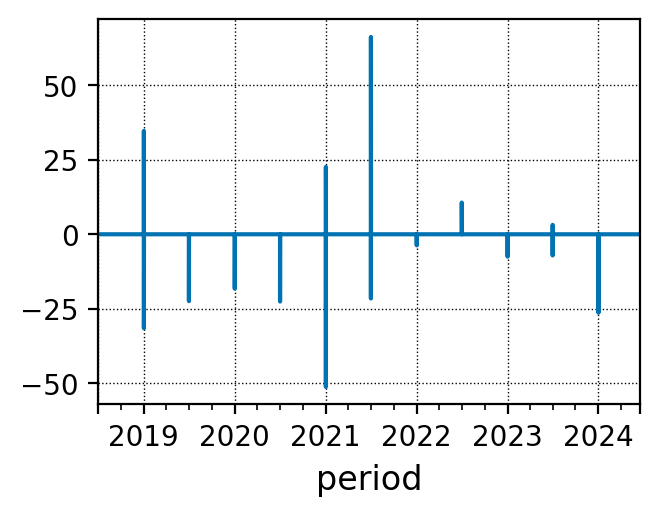

In [87]:
(co2iD - co2iD2).plot()

In [79]:
pd.DataFrame({"v1": co2iD.loc[co2iD != co2iD2], "v2": co2iD2.loc[co2iD != co2iD2]})

,v1,v2
period,,
2018-07-01 09:00:00,269.970188,269.970188
2018-07-01 10:00:00,267.625136,267.625136
2018-07-01 16:00:00,330.809785,330.809785
2018-07-01 17:00:00,337.997439,337.997439
2018-07-02 01:00:00,347.848725,347.848725
...,...,...
2024-06-14 14:00:00,268.599752,268.599752
2024-06-14 15:00:00,271.489138,271.489138
2024-06-14 17:00:00,282.156856,282.156856


In [64]:
co2i.df.index

DatetimeIndex(['2018-07-01 05:00:00', '2018-07-01 06:00:00',
               '2018-07-01 07:00:00', '2018-07-01 08:00:00',
               '2018-07-01 09:00:00', '2018-07-01 10:00:00',
               '2018-07-01 11:00:00', '2018-07-01 12:00:00',
               '2018-07-01 13:00:00', '2018-07-01 14:00:00',
               ...
               '2024-06-14 22:00:00', '2024-06-14 23:00:00',
               '2024-06-15 00:00:00', '2024-06-15 01:00:00',
               '2024-06-15 02:00:00', '2024-06-15 03:00:00',
               '2024-06-15 04:00:00', '2024-06-15 05:00:00',
               '2024-06-15 06:00:00', '2024-06-15 07:00:00'],
              dtype='datetime64[ns]', name='period', length=52227, freq=None)

In [48]:
import numpy as np

def filter_cols(gd: Union[pd.DataFrame, ge.GraphData], balancing_regions: List[str]) -> pd.DataFrame:
    """ """
    if isinstance(gd, pd.DataFrame):
        df = gd
    elif isinstance(gd, ge.GraphData):
        df = gd.df
    else:
        raise ValueError(f"Unexpected type for gd: {type(gd)}")

    cols_to_keep = [col for col in df.columns if np.any([br in col for br in balancing_regions])]
    return df.loc[:, cols_to_keep]

def load_bulk2(
        path: Union[str, Path],
        balancing_region: Union[str, List[str]],
        which: Union[str, List[str]] = ["elec"],
        ) -> pd.DataFrame:

    if isinstance(balancing_region, str):
        balancing_regions = [balancing_region]
    if isinstance(which, str):
        which = [which]
    if not set(which).issubset(["elec", "co2", "co2i", "raw", "basic", "rolling", "opt"]):
        raise ValueError(f"Unexpected value for which: {which}")
    if isinstance(path, str):
        path = Path(path)

    files = [f for f in path.iterdir() if f.stem.split("_")[-1] in which]
    result = pd.concat(
            [filter_cols(
                pd.read_csv(path, index_col=0, parse_dates=True),
                balancing_regions,
                ) for path in files
                ],
            axis=0,
        )
    result.sort_index(inplace=True)
    result = result[~result.index.duplicated(keep="last")]

    return result

In [49]:
result = load_bulk("../data/interim/gridemissions", "ISNE", ["elec", "co2i"])

In [51]:
print(list(result.columns))

['E_ISNE_NG', 'E_ISNE_D', 'E_ISNE_TI', 'E_ISNE-NYIS_ID', 'E_ISNE-HQT_ID', 'E_ISNE-NBSO_ID', 'E_NYIS-ISNE_ID', 'E_HQT-ISNE_ID', 'E_NBSO-ISNE_ID', 'E_ISNE_COL', 'E_ISNE_GAS', 'E_ISNE_NUC', 'E_ISNE_OIL', 'E_ISNE_OTH', 'E_ISNE_SUN', 'E_ISNE_UNK', 'E_ISNE_WAT', 'E_ISNE_WND', 'CO2i_ISNE_D']


In [56]:
result.loc["2020-07-01 03:00:00"]

E_ISNE_NG                NaN
E_ISNE_D                 NaN
E_ISNE_TI                NaN
E_ISNE-NYIS_ID           NaN
E_ISNE-HQT_ID            NaN
E_ISNE-NBSO_ID           NaN
E_NYIS-ISNE_ID           NaN
E_HQT-ISNE_ID            NaN
E_NBSO-ISNE_ID           NaN
E_ISNE_COL               NaN
E_ISNE_GAS               NaN
E_ISNE_NUC               NaN
E_ISNE_OIL               NaN
E_ISNE_OTH               NaN
E_ISNE_SUN               NaN
E_ISNE_UNK               NaN
E_ISNE_WAT               NaN
E_ISNE_WND               NaN
CO2i_ISNE_D       265.823049
Name: 2020-07-01 03:00:00, dtype: float64

In [16]:
result.df["E_ISNE_GAS"]

period
2018-07-01 05:00:00    7063.746853
2018-07-01 06:00:00    6379.167973
2018-07-01 07:00:00    6351.119715
2018-07-01 08:00:00    6206.892876
2018-07-01 09:00:00    5926.454104
                          ...     
2024-06-15 03:00:00    7474.313405
2024-06-15 04:00:00    6484.059690
2024-06-15 05:00:00    6125.695667
2024-06-15 06:00:00    5723.066305
2024-06-15 07:00:00    5234.787745
Name: E_ISNE_GAS, Length: 52227, dtype: float64

In [17]:
[col for col in result.df.columns if col.startswith("E_ISNE")]

['E_ISNE_NG',
 'E_ISNE_D',
 'E_ISNE_TI',
 'E_ISNE-NYIS_ID',
 'E_ISNE-HQT_ID',
 'E_ISNE-NBSO_ID',
 'E_ISNE_COL',
 'E_ISNE_GAS',
 'E_ISNE_NUC',
 'E_ISNE_OIL',
 'E_ISNE_OTH',
 'E_ISNE_SUN',
 'E_ISNE_UNK',
 'E_ISNE_WAT',
 'E_ISNE_WND']

In [18]:
result.regions

['AECI',
 'AEC',
 'AVA',
 'AVRN',
 'AZPS',
 'BANC',
 'BPAT',
 'CHPD',
 'CISO',
 'CPLE',
 'CPLW',
 'DEAA',
 'DOPD',
 'DUK',
 'EPE',
 'ERCO',
 'FMPP',
 'FPC',
 'FPL',
 'GCPD',
 'GLHB',
 'GRID',
 'GRIF',
 'GVL',
 'GWA',
 'HGMA',
 'HST',
 'IID',
 'IPCO',
 'ISNE',
 'JEA',
 'LDWP',
 'LGEE',
 'MISO',
 'NEVP',
 'NWMT',
 'NYIS',
 'PACE',
 'PACW',
 'PGE',
 'PJM',
 'PNM',
 'PSCO',
 'PSEI',
 'SCEG',
 'SCL',
 'SC',
 'SEC',
 'SEPA',
 'SOCO',
 'SPA',
 'SRP',
 'SWPP',
 'TAL',
 'TEC',
 'TEPC',
 'TIDC',
 'TPWR',
 'TVA',
 'WACM',
 'WALC',
 'WAUW',
 'WWA',
 'YAD',
 'BCHA',
 'CEN',
 'HQT',
 'NBSO',
 'IESO',
 'MHEB',
 'AESO',
 'SPC',
 'EEI',
 'NSB',
 'OVEC']